# Coursework 1
In this assignment, you will implement a decision tree algorithm and use it to determine one of the indoor locations based on WIFI signal strengths collected from a mobile phone.

## Step 1: Loading data
You can load the datasets from the files `wifi_db/clean_dataset.txt` and `wifi_db/noise_dataset.txt`. They contain a 2000x8 array.

This array represents a dataset of 2000 samples. Each sample is composed of 7 wifi signal strengths while the last column indicates the room number in which the user is standing (i.e. the label of the sample). **All the features in the dataset are continuous _except_ the room number.**

In [4]:
# Import required modules
import numpy as np
from numpy.random import default_rng

In [5]:
# Load in the datasets
clean_dataset = np.loadtxt('wifi_db/clean_dataset.txt')
noisy_dataset = np.loadtxt('wifi_db/noisy_dataset.txt')

print(clean_dataset)
print(noisy_dataset)

[[-64. -56. -61. ... -82. -81.   1.]
 [-68. -57. -61. ... -85. -85.   1.]
 [-63. -60. -60. ... -85. -84.   1.]
 ...
 [-62. -59. -46. ... -87. -88.   4.]
 [-62. -58. -52. ... -90. -85.   4.]
 [-59. -50. -45. ... -88. -87.   4.]]
[[-59. -53. -51. ... -79. -87.   4.]
 [-66. -53. -59. ... -81. -79.   1.]
 [-41. -57. -63. ... -66. -65.   2.]
 ...
 [-57. -54. -56. ... -79. -82.   1.]
 [-56. -52. -50. ... -85. -88.   3.]
 [-46. -54. -47. ... -80. -73.   3.]]


## Step 2: Creating Decision Trees
To create the decision tree, you will write a recursive function called `decision_tree_learning()`, that takes as arguments a matrix containing the dataset and a depth variable (which is used to compute the maximal depth of the tree, for plotting purposes for instance). The label of the training dataset is assumed to be the last column of the matrix.

See the psuedo-code for the algorithm below.
```
1:  procedure DECISION_TREE_LEARNING(training_dataset, depth)
2:    if all samples have the same label then
3:      return (a leaf node with this value, depth)
4:    else
5:      split ← FIND_SPLIT(training dataset)
6:      node ← a new decision tree with root as split value
7:      l_branch, l_depth ← DECISION_TREE_LEARNING(l_dataset, depth+1)
8:      r_branch, r_depth ← DECISION_TREE_LEARNING(r_dataset, depth+1)
9:      return (node, max(l_depth, r_depth))
10:   end if
11: end procedure
```

The function `FIND_SPLIT` chooses the attribute and the value that results in the highest information gain.

An efficient method for finding good split points is to sort the values of the attribute, and then consider only split points that are **between two examples in sorted order**, while keeping track of the running totals of examples of each class for each side of the split point.

To evaluate the information gain, suppose that the training dataset S_all has K different labels. We can define two subsets (S_left and S_right) of the dataset depending on the splitting rule and for each dataset and subset, we can compute the distribution (or probability) of each label. For instance, {p1, p2, ..., pk} where pk is the number of samples with the label k divided by the total number of samples from the initial dataset.

In [41]:
"""
Class used to represent decision nodes in a decision tree.

Members:
- value     : the value on which to split
- attribute : the attribute on which to split
- left      : the left sub-tree
- right     : the right sub-tree

Methods:
- is_leaf : returns a boolean indicating whether or not this is a leaf node
"""
class Node:
    def __init__(self, value = None, attribute = None):
        self.value = value
        self.attribute = attribute
        self.left = None
        self.right = None
        self.label = None
    
    def is_leaf(self):
        return self.left is None and self.right is None

In [7]:
"""
Chooses the attribute and the value that results in the highest information gain

Arguments:
- training_dataset (last column is the label)

Returns:
- tuple : Returns a tuple of (split_attribute, split_value, left_dataset, right_dataset)
          - split_attribute: The column index of the value that was split on
          - split_value: The value used to split the dataset into left and right
          - left_dataset: All elements have a `split_attribute` value < `split_value`
          - right_dataset: All elements have a `split_attribute` value >= `split_value`
"""
def find_split(training_dataset):
    best_split = (0, None)

    for attribute in range(training_dataset.shape[1] - 1):
        # Sort the rows by the current attribute's values
        sorted_attribute_indices = np.argsort(training_dataset, axis=0)[:, attribute]
        sorted_by_attribute = training_dataset[sorted_attribute_indices, :]
        # Get the index of each point where the value changes
        _, split_points = np.unique(sorted_by_attribute[:, attribute], return_index=True)
        for split_point in split_points:
            # Find the information gained from splitting at this point
            left = sorted_by_attribute[:split_point, :]
            right = sorted_by_attribute[split_point:, :]
            info_gain = information_gain(training_dataset, left, right)
            split_value = sorted_by_attribute[split_point, attribute]
            # Replace best_split if more information is gained by splitting here
            best_split = max(best_split, (info_gain, (attribute, split_value, left, right)), key=lambda x: x[0])

    return best_split[1]

# Returns the information gain when the dataset `data` is split into two distinct subsets `left` and `right`
def information_gain(data, left, right):
    return entropy(data) - remainder(left, right)

# Returns the information entropy of `dataset`
def entropy(dataset):
    _, counts = np.unique(dataset[:, -1], return_counts=True)
    probabilities = counts / counts.sum()
    return -(probabilities * np.log2(probabilities)).sum()

# Returns the (weighted) average entropy of the two subsets `left` and `right`
def remainder(left, right):
    proportion_left = len(left) / (len(left) + len(right))
    return proportion_left * entropy(left) + (1 - proportion_left) * entropy(right)

In [127]:
"""
Constructs a decision tree by learning from training_dataset.

Arguments:
- training_dataset (last column is the label)
- depth

Returns:
- A decision tree in the form of a root Node and subsequent left and right nodes
"""
def decision_tree_learning(training_dataset, depth):
    unique_labels = np.unique(training_dataset[:,-1])
    # If all samples have the same label return a leaf node with this label
    if (len(unique_labels) == 1):
        node = Node()
        node.label = unique_labels[0]
        return (node, depth)
    else:
        # Find the optimum split attribute and value and the corresponding split subsets
        split_attribute, split_value, left_dataset, right_dataset = find_split(training_dataset)
        # Create a new decision tree with this split value and attribute
        node = Node(split_value, split_attribute)
        # Construct the rest of the decision tree
        left_branch, left_depth = decision_tree_learning(left_dataset, depth + 1)
        right_branch, right_depth = decision_tree_learning(right_dataset, depth + 1)
        # Assign these branches to the root node
        node.left = left_branch
        node.right = right_branch
        
        return (node, max(left_depth, right_depth))

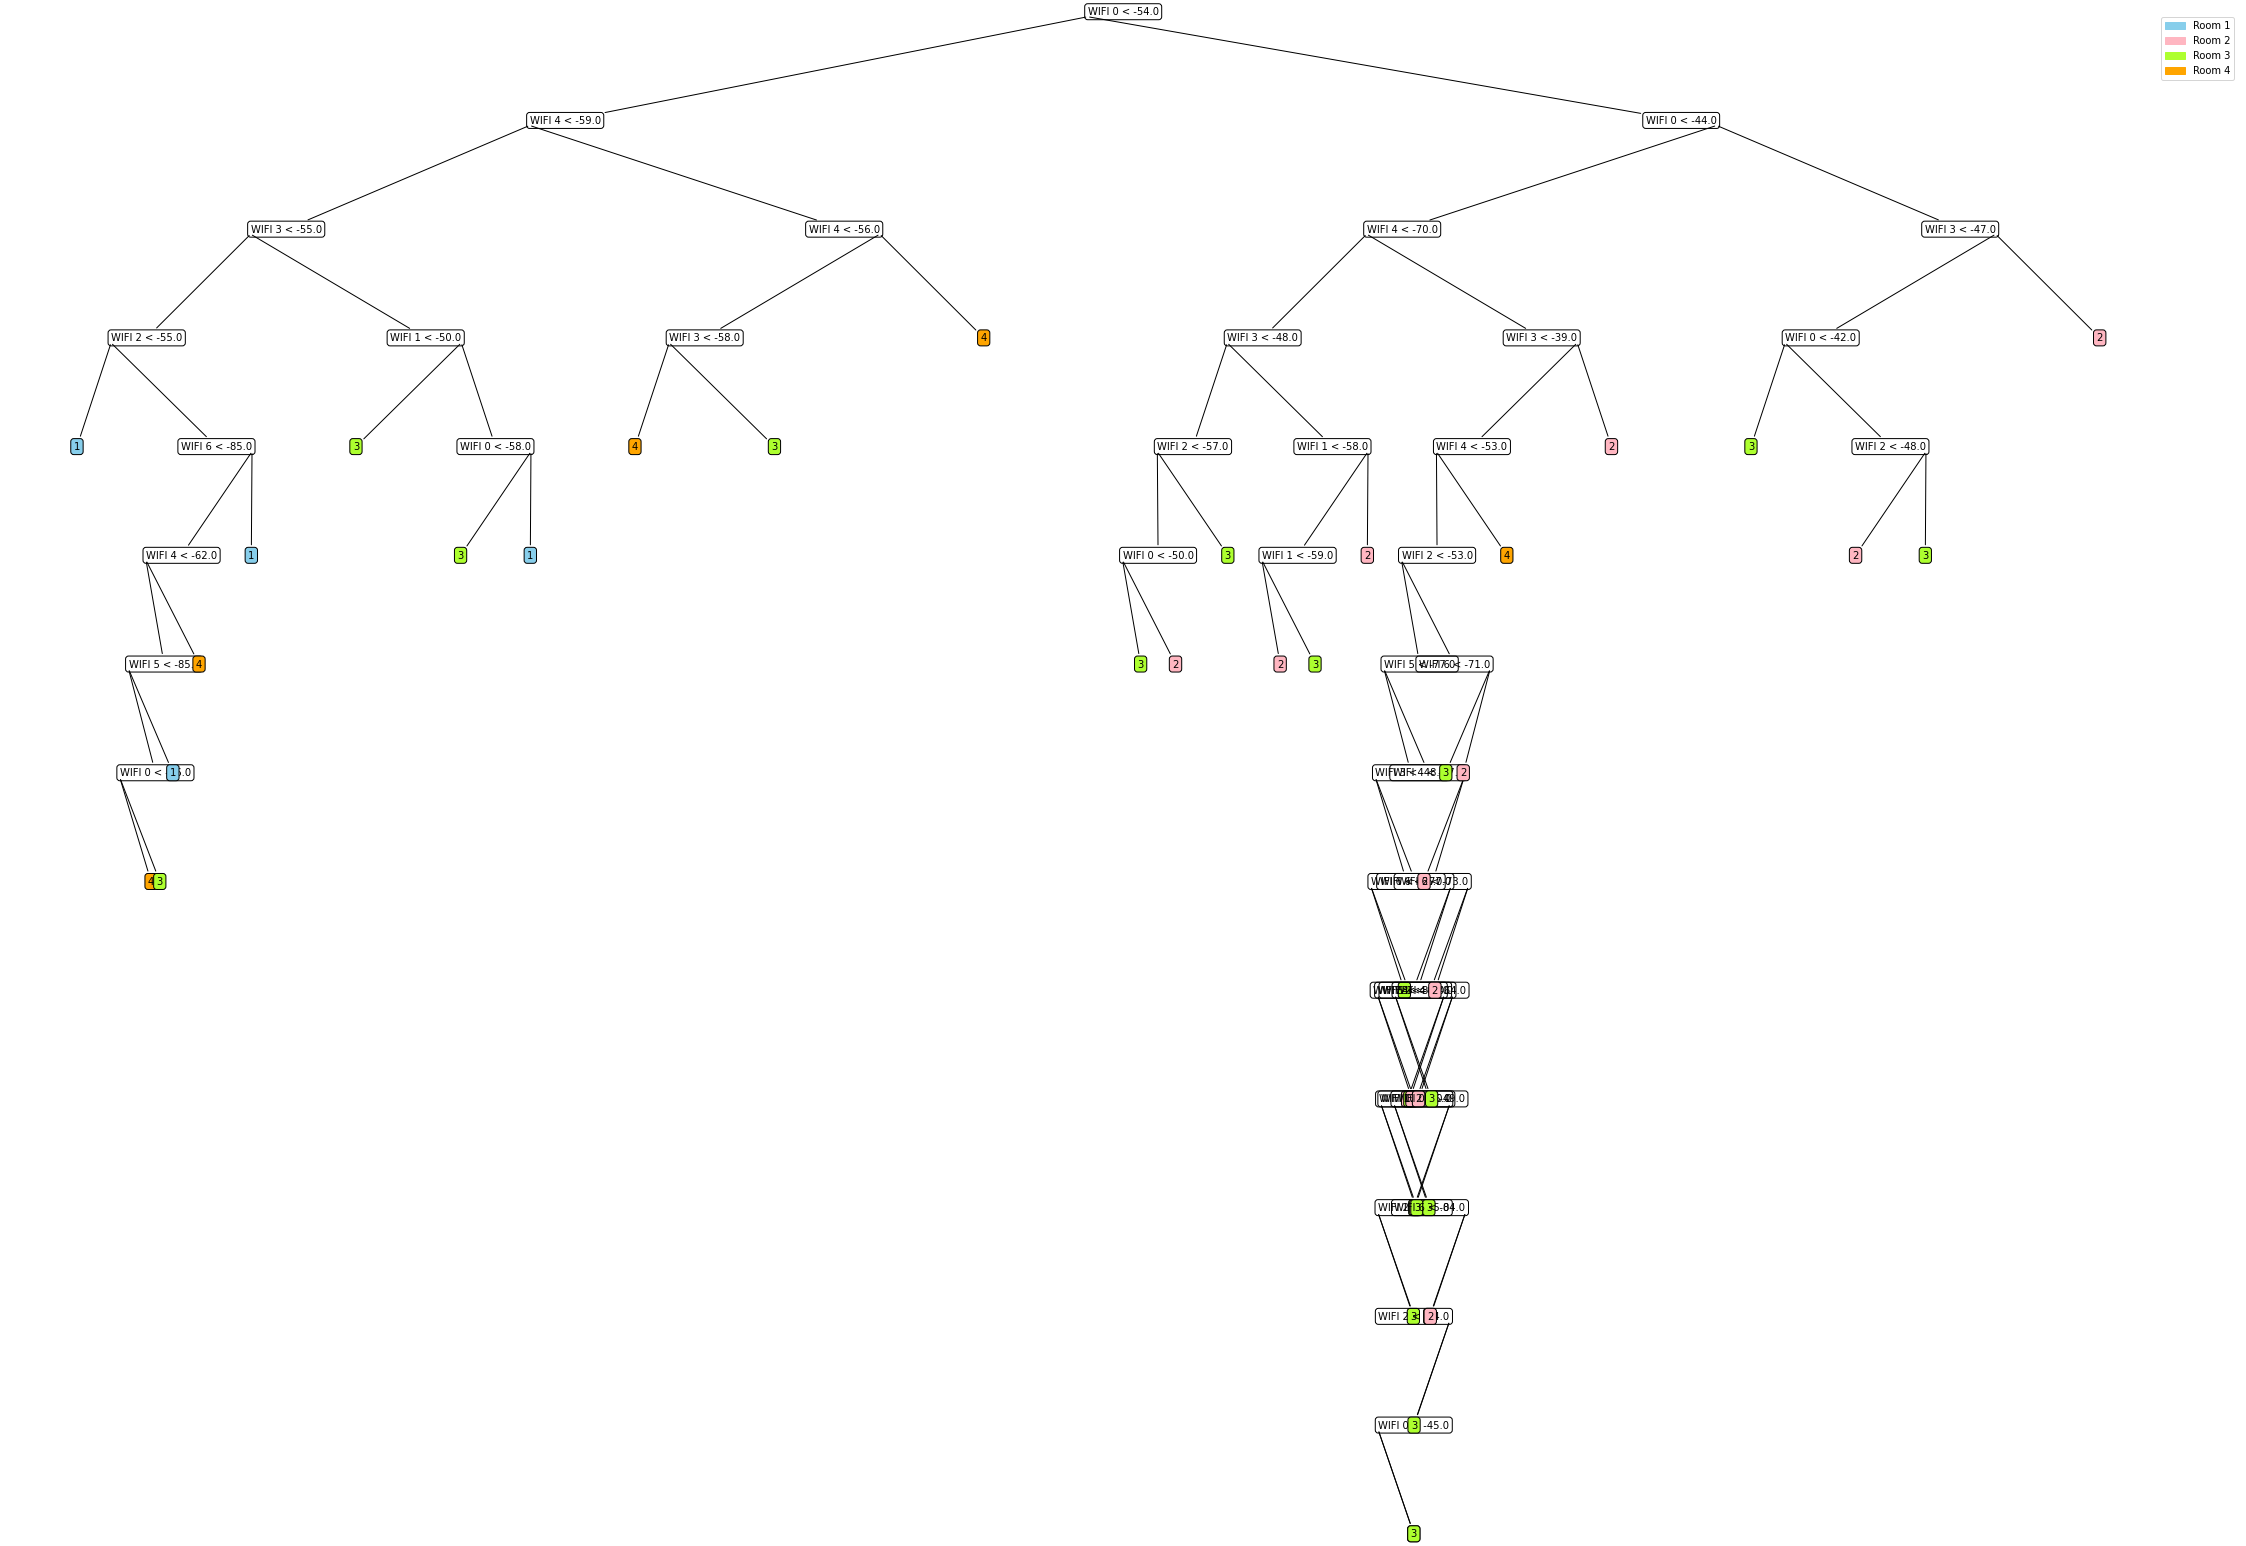

In [159]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

root_node, depth = decision_tree_learning(clean_dataset, 0)

def visualise_tree(tree):
    y_gap = 0.1
    def visualise_children(parent_node, parent_text, left_x, right_x, y, parent_is_left, depth=0):
        # if depth == 2:
        #     return
        
        # Calculate position
        mids = left_x + (right_x - left_x) * np.array([0.25, 0.5, 0.75])
        y -= y_gap
        xy = (0, 0) if parent_is_left else (1, 0)
        
        # Plot child text box
        # Them recursively plot children of children
        if parent_node.left:
            left_plot = plot_node(parent_node.left, parent_text, xy, (mids[0], y))
            visualise_children(parent_node.left, left_plot, left_x, mids[1], y, True, depth+1)

        if parent_node.right:
            right_plot = plot_node(parent_node.right, parent_text, xy, (mids[2], y))
            visualise_children(parent_node.right, right_plot, mids[1], right_x, y, False, depth+1)

    def plot_node(node, parent_text, xy, xytext):
        # Formatting and adjustments
        text = int(node.label) if node.is_leaf() else f"WIFI {node.attribute} < {node.value}"
        facecolor = f"{roomColors[int(node.label)]}" if node.is_leaf() else "none"

        # Plot text box
        return ax.annotate(text, xy=xy, xycoords=parent_text,
                                xytext=xytext, textcoords="axes fraction",
                                va="center", ha="center",
                                bbox=dict(facecolor=facecolor, alpha=1, boxstyle="round"),
                                arrowprops=dict(arrowstyle="-"))

    def generate_legend():
        for room, color in roomColors.items():
            handles.append(mpatches.Patch(color=color, label=f"Room {room}"))

    width, height = 40, 20 # feel free to increase width to spread out the tree
    roomColors = {1 : 'skyblue', 2 : 'lightpink', 3 : 'greenyellow', 4 : 'orange'}
    handles = []
    generate_legend()

    _, ax = plt.subplots(figsize=(width, height))
    ax.set_axis_off()

    root_text = plot_node(tree, "data", (0.5, 1), (0.5, 1))
    visualise_children(root_node, root_text, 0, 1, 1, True)    
    
    plt.legend(handles=handles)
    plt.show()

visualise_tree(root_node)

## Step 3: Evaluation
Evaluate your decision tree using a 10-fold cross validation on both the clean and noisy datasets. You should expect that slightly different trees will be created with each fold, since the training data that you use each time will be slightly different. Use your resulting decision trees to classify your data in your test sets.

Implement an evaluation function that takes a trained tree and a test dataset: `evaluate(test_db, trained_tree)` and that returns the accuracy of the tree.

In [170]:
"""
Decides a label for this set of features using tree

Arguments:
- features : a single example of training data
- tree     : decision tree
"""
def decide_label(features, tree):
    if (tree.is_leaf()):
        return tree.label
    
    if (features[tree.attribute] < tree.value):
        return decide_label(features, tree.left)
    else:
        return decide_label(features, tree.right)

def predict(test_db, trained_tree):
    predictions = np.zeros(len(test_db))
    for i, row in enumerate(test_db):
        predictions[i] = decide_label(row[:-1], trained_tree)
    return predictions


"""
Evaluates the performance of trained_tree on test_db

Arguments:
- test_db      : data used for testing (last column is label)
- trained_tree : trained decision tree

Returns:
- accuracy (float)
"""
def evaluate(test_db, trained_tree):
    predictions = predict(test_db, trained_tree)
    return np.sum(test_db[:, -1] == predictions) / len(test_db)

In [171]:
# shuffled_indices = default_rng().permutation(len(clean_dataset))
# shuffled_dataset = clean_dataset[shuffled_indices, :]
# tree, depth = decision_tree_learning(shuffled_dataset[:1800, :], 0)
# print(evaluate(shuffled_dataset[1800:, :], tree))

def train_test_k_fold(n_instances, n_folds=10):
    shuffled_indices = default_rng().permutation(n_instances)
    split_indices = np.array_split(shuffled_indices, n_folds)
    folds = []

    for k in range(n_folds):
        test_indices = split_indices[k] 
        train_indices = np.concatenate(split_indices[:k] + split_indices[k+1:])
        folds.append([train_indices, test_indices])
    
    return folds

In [172]:
"""
Perform k_fold cross-validation and return the predictions and labels
"""
def cross_validation(dataset):
    predictions = []
    labels = []
    for _, (train_indices, test_indices) in enumerate(train_test_k_fold(len(dataset), 10)):
        train_set = dataset[train_indices]
        test_set = dataset[test_indices]
        tree, _ = decision_tree_learning(train_set, 0)

        predictions.append(predict(test_set, tree))
        labels.append(test_set[:, -1])

    return predictions, labels


In [1]:
"""
Compute the confusion matrix.
    
Argumentss:
- y_gold (np.ndarray): the correct ground truth/gold standard labels
- y_prediction (np.ndarray): the predicted labels
- class_labels (np.ndarray): a list of unique class labels. 
                        Defaults to the union of y_gold and y_prediction.

Returns:
- np.array : shape (C, C), where C is the number of classes. 
            Rows are ground truth per class, columns are predictions
"""
def confusion_matrix(y_gold, y_prediction, class_labels):
  
    confusion = np.zeros((len(class_labels), len(class_labels)))

    # for each correct class (row), 
    # compute how many instances are predicted for each class (columns)
    for i, row_label in enumerate(class_labels):
      ground_indices = y_gold == row_label
      label_predictions = y_prediction[ground_indices]
      labels, prediction_counts = np.unique(label_predictions, return_counts=True)
      
      label_dict = dict(zip(labels, prediction_counts))

      for j, column_label in enumerate(class_labels):
        confusion[i, j] = label_dict.get(column_label, 0)


    return confusion


def avg_confusion_matrix(predictions, labels, class_labels=None):
    if not class_labels:
        class_labels = np.unique(np.concatenate((np.vstack(predictions), np.vstack(labels)))) 
    totals = np.zeros((len(class_labels), len(class_labels)))
    for i in range(len(predictions)):
      totals += confusion_matrix(labels[i], predictions[i], class_labels)

    return totals / len(predictions)


In [174]:
"""
Compute the accuracy given the confusion matrix

Args:
- confusion (np.ndarray): shape (C, C), where C is the number of classes. 
            Rows are ground truth per class, columns are predictions

Returns:
- float : the accuracy
"""    
def accuracy_from_confusion(confusion):
    if np.sum(confusion) > 0:
        return np.sum(np.diag(confusion)) / np.sum(confusion)
    else:
        return 0.

In [175]:
"""
Compute the precision score per class given the ground truth and predictions
    
Also return the macro-averaged precision across classes.
    
Args:
- y_gold (np.ndarray): the correct ground truth/gold standard labels
- y_prediction (np.ndarray): the predicted labels

Returns:
- precisions is a np.ndarray of shape (C,), where each element is the 
    precision for class c
"""
def precision(confusion):

    # Compute the precision per class
    p = np.zeros(len(confusion))

    for i in range(len(confusion)):
        if np.sum(confusion[:, i]) > 0:
            p[i] = confusion[i, i] / np.sum(confusion[:,i])
    
    return p

In [176]:
"""
Compute the recall score per class given the ground truth and predictions
    
Also return the macro-averaged recall across classes.
    
Args:
- y_gold (np.ndarray): the correct ground truth/gold standard labels
- y_prediction (np.ndarray): the predicted labels

Returns:
- recalls is a np.ndarray of shape (C,), where each element is the 
    recall for class c
"""
def recall(confusion):
    # Compute the recall per class
    r = np.zeros(len(confusion))

    for i in range(len(confusion)):
        if np.sum(confusion[i, :]) > 0:
            r[i] = confusion[i, i] / np.sum(confusion[i])
    
    return r

In [184]:
def f1(confusion):
    recalls, precisions = recall(confusion), precision(confusion)

    f = np.zeros(len(confusion))
    for i, (r, p) in enumerate(zip(recalls, precisions)):
        f[i] = 2 * r * p / (r + p)

    return f

In [190]:
predictions, labels = cross_validation(noisy_dataset)
confusion = avg_confusion_matrix(predictions, labels)
print(confusion)
print(accuracy_from_confusion(confusion))
print(recall(confusion))
print(precision(confusion))
print(f1(confusion))

[[38.   4.   4.   3. ]
 [ 3.  40.   4.2  2.5]
 [ 2.6  3.6 42.1  3.2]
 [ 4.3  2.1  4.1 39.3]]
0.7969999999999999
[0.7755102  0.80482897 0.81747573 0.78915663]
[0.79331942 0.80482897 0.77389706 0.81875   ]
[0.78431373 0.80482897 0.79508971 0.80368098]
